# 02: Baseline Models - TF-IDF + Classical ML

This notebook trains and evaluates baseline models using TF-IDF features with classical machine learning classifiers.

**Models trained:**
1. **TF-IDF + Logistic Regression** - Fast, interpretable, strong baseline
2. **TF-IDF + Linear SVM** - Alternative classifier for comparison
3. **TF-IDF + Naive Bayes** - Probabilistic baseline

**Why TF-IDF?**
- Simple but effective for text classification
- Fast training and inference
- Interpretable (can examine feature importance)
- Often competitive with deep learning for keyword-based tasks

**Outputs:**
- Model performance metrics
- Confusion matrices
- Feature importance analysis
- Results saved to `experiments/results/`

## Setup

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Import our modules
from src.data_loader import load_and_prepare_data
from src.models import TFIDFModel
from src.evaluate import (
    evaluate_model, 
    plot_confusion_matrix, 
    plot_per_genre_metrics,
    compare_models,
    create_results_table
)
from src.utils import set_seed, GENRES, ID_TO_GENRE

# Set random seed for reproducibility
set_seed(42)

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Setup complete!")

/home/jovyan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


✅ Random seed set to 42
✓ Setup complete!


## 1. Load Preprocessed Data

Load the balanced dataset created in Notebook 01.

**Note:** Adjust `samples_per_genre` based on your computational resources:
- **Quick testing:** 5,000 samples/genre (25K total)
- **Standard:** 20,000 samples/genre (100K total)
- **Full dataset:** 100,000 samples/genre (500K total)

In [2]:
# Configuration
SAMPLES_PER_GENRE = 20000  # Adjust based on your needs
TEST_SIZE = 0.2

print(f"Loading data with {SAMPLES_PER_GENRE:,} samples per genre...\n")

# Load and split data
X_train, X_test, y_train, y_test = load_and_prepare_data(
    samples_per_genre=SAMPLES_PER_GENRE,
    test_size=TEST_SIZE,
    use_cached=True,
    random_state=42
)

print(f"\n✓ Data loaded successfully!")
print(f"  Training set: {len(X_train):,} samples")
print(f"  Test set: {len(X_test):,} samples")
print(f"  Classes: {len(GENRES)}")

Loading data with 20,000 samples per genre...

✅ Random seed set to 42
Loading cached balanced dataset from /home/jovyan/Desktop/NLP/Project/data/song_lyrics_balanced.csv

Balancing dataset to 20,000 samples per genre...
  country: 20,000
  pop: 20,000
  rap: 20,000
  rb: 20,000
  rock: 20,000

✅ Balanced dataset: 100,000 songs

✅ Train/Test split:
   Training: 80,000 samples
   Test: 20,000 samples

✓ Data loaded successfully!
  Training set: 80,000 samples
  Test set: 20,000 samples
  Classes: 5


## 2. Model 1: TF-IDF + Logistic Regression

Our primary baseline model. Logistic Regression is:
- Fast to train
- Provides probability estimates
- Allows feature importance analysis
- Well-suited for multiclass text classification

In [3]:
# Train TF-IDF + Logistic Regression
print("Training TF-IDF + Logistic Regression...\n")

start_time = time.time()

model_lr = TFIDFModel(
    classifier_type='logistic',
    max_features=10000,
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=5,
    max_df=0.8
)

model_lr.fit(X_train, y_train)

train_time_lr = time.time() - start_time
print(f"\n⏱️  Training time: {train_time_lr:.2f} seconds")

Training TF-IDF + Logistic Regression...

Training TF-IDF + logistic...
  TF-IDF features: 10,000
✅ Training complete

⏱️  Training time: 65.57 seconds


### Evaluate Logistic Regression

In [4]:
# Make predictions
y_pred_lr = model_lr.predict(X_test)

# Evaluate
results_lr = evaluate_model(y_test, y_pred_lr, model_name="TF-IDF + Logistic Regression")

print(f"\n{'='*80}")
print(f"TF-IDF + LOGISTIC REGRESSION RESULTS")
print(f"{'='*80}")
print(f"Accuracy: {results_lr['accuracy']:.4f}")
print(f"Macro F1: {results_lr['macro_avg']['f1']:.4f}")
print(f"Weighted F1: {results_lr['weighted_avg']['f1']:.4f}")
print(f"Training time: {train_time_lr:.2f}s")
print(f"{'='*80}")

TF-IDF + LOGISTIC REGRESSION EVALUATION RESULTS

Overall Accuracy: 0.6045

Per-Genre Performance:
Genre        Precision    Recall       F1-Score     Support
----------------------------------------------------------------------
country      0.6538       0.7077       0.6797       4000
pop          0.4124       0.3660       0.3878       4000
rap          0.7754       0.8017       0.7883       4000
rb           0.6136       0.5887       0.6009       4000
rock         0.5384       0.5580       0.5480       4000

TF-IDF + LOGISTIC REGRESSION RESULTS
Accuracy: 0.6045
Macro F1: 0.6010
Weighted F1: 0.6010
Training time: 65.57s


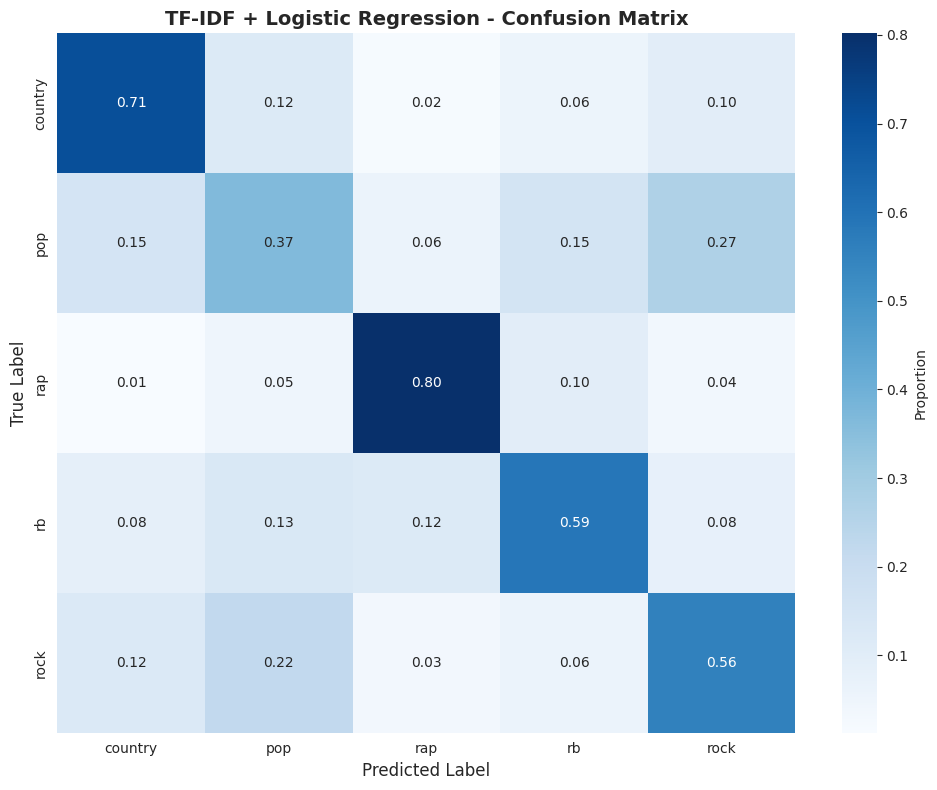

In [5]:
# Confusion matrix
plot_confusion_matrix(
    y_test, 
    y_pred_lr,
    title="TF-IDF + Logistic Regression - Confusion Matrix",
    normalize=True
)

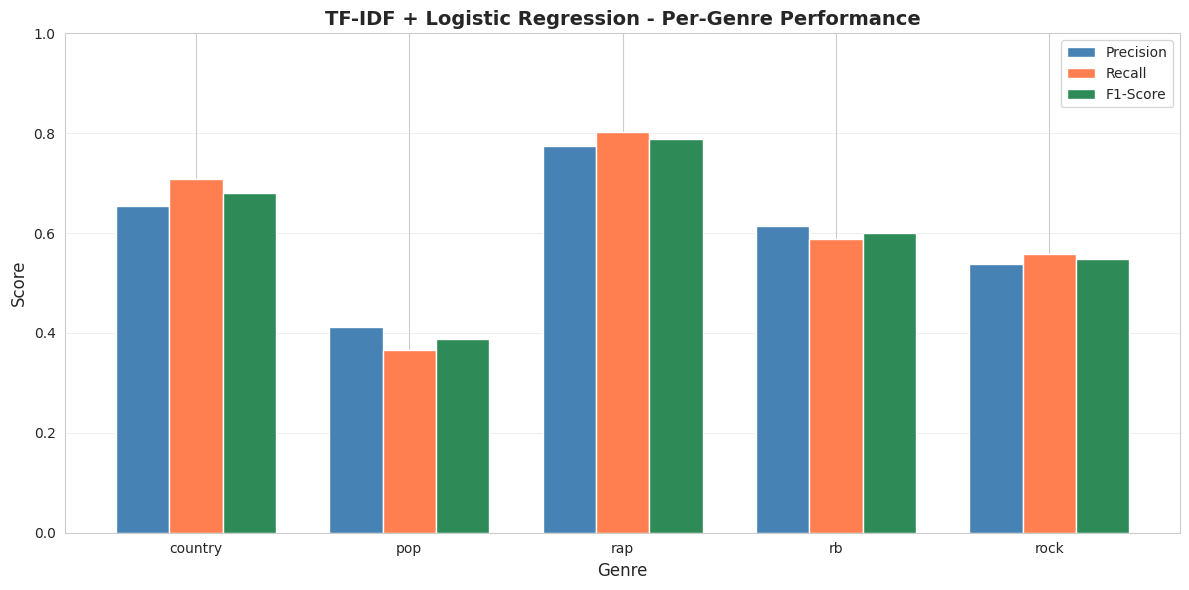

In [6]:
# Per-genre performance
plot_per_genre_metrics(
    results_lr,
    title="TF-IDF + Logistic Regression - Per-Genre Performance"
)

### Feature Importance Analysis

Examine which words are most important for each genre classification.

In [7]:
# Get top features for each genre
feature_importance = model_lr.get_feature_importance(top_n=15)

print("Top 15 predictive features per genre:\n")
print("="*80)

for genre_id, features in feature_importance.items():
    genre_name = ID_TO_GENRE[genre_id]
    print(f"\n{genre_name.upper()}:")
    
    # Display as DataFrame for nice formatting
    df_features = pd.DataFrame(features, columns=['Feature', 'Weight'])
    df_features['Weight'] = df_features['Weight'].round(4)
    print(df_features.to_string(index=False))
    print("-" * 40)

Top 15 predictive features per genre:


COUNTRY:
   Feature  Weight
     bölüm  6.0844
   country  4.6089
       and  4.5898
     truck  4.4208
   whiskey  4.2512
       old  4.1374
       ain  3.6695
      town  3.4036
    taylor  3.3873
verse well  3.2322
      beer  3.2299
    cowboy  3.1518
    little  3.1514
      well  2.9142
      dear  2.7631
----------------------------------------

POP:
   Feature  Weight
      drop  2.8130
       pre  2.5739
     amore  2.4297
     liebe  2.2522
       cos  2.2138
       och  2.0690
      amor  1.9801
    bailar  1.9098
     amour  1.8871
     feliz  1.6851
       weh  1.6847
        åh  1.6725
 surrender  1.6325
pre chorus  1.6066
       dey  1.5867
----------------------------------------

RAP:
Feature  Weight
   hook  8.9094
    rap  7.2677
   shit  4.4579
couplet  4.2704
   fuck  4.2407
  bitch  4.1691
   like  3.8570
   yeah  3.7976
   flow  3.6717
  intro  3.5476
    lil  3.3962
    mic  3.2518
   gang  3.0134
     mc  2.9934
  tryna  

## 3. Model 2: TF-IDF + Linear SVM

Support Vector Machines often perform well on text classification.
Let's compare with Logistic Regression.

In [8]:
# Train TF-IDF + SVM
print("Training TF-IDF + Linear SVM...\n")

start_time = time.time()

model_svm = TFIDFModel(
    classifier_type='svm',
    max_features=10000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8
)

model_svm.fit(X_train, y_train)

train_time_svm = time.time() - start_time
print(f"\n⏱️  Training time: {train_time_svm:.2f} seconds")

Training TF-IDF + Linear SVM...

Training TF-IDF + svm...
  TF-IDF features: 10,000
✅ Training complete

⏱️  Training time: 66.87 seconds


### Evaluate SVM

In [9]:
# Make predictions
y_pred_svm = model_svm.predict(X_test)

# Evaluate
results_svm = evaluate_model(y_test, y_pred_svm, model_name="TF-IDF + Linear SVM")

print(f"\n{'='*80}")
print(f"TF-IDF + LINEAR SVM RESULTS")
print(f"{'='*80}")
print(f"Accuracy: {results_svm['accuracy']:.4f}")
print(f"Macro F1: {results_svm['macro_avg']['f1']:.4f}")
print(f"Weighted F1: {results_svm['weighted_avg']['f1']:.4f}")
print(f"Training time: {train_time_svm:.2f}s")
print(f"{'='*80}")

TF-IDF + LINEAR SVM EVALUATION RESULTS

Overall Accuracy: 0.5828

Per-Genre Performance:
Genre        Precision    Recall       F1-Score     Support
----------------------------------------------------------------------
country      0.6345       0.6995       0.6654       4000
pop          0.3952       0.3225       0.3552       4000
rap          0.7435       0.7963       0.7690       4000
rb           0.5832       0.5625       0.5727       4000
rock         0.5100       0.5335       0.5215       4000

TF-IDF + LINEAR SVM RESULTS
Accuracy: 0.5828
Macro F1: 0.5767
Weighted F1: 0.5767
Training time: 66.87s


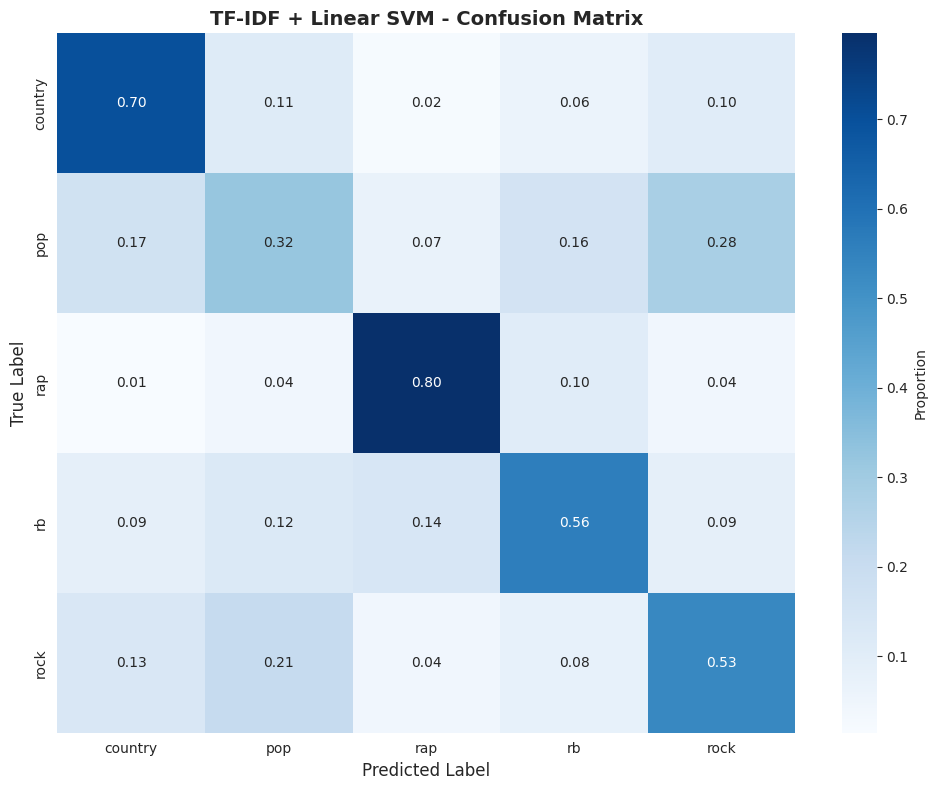

In [10]:
# Confusion matrix
plot_confusion_matrix(
    y_test, 
    y_pred_svm,
    title="TF-IDF + Linear SVM - Confusion Matrix",
    normalize=True
)

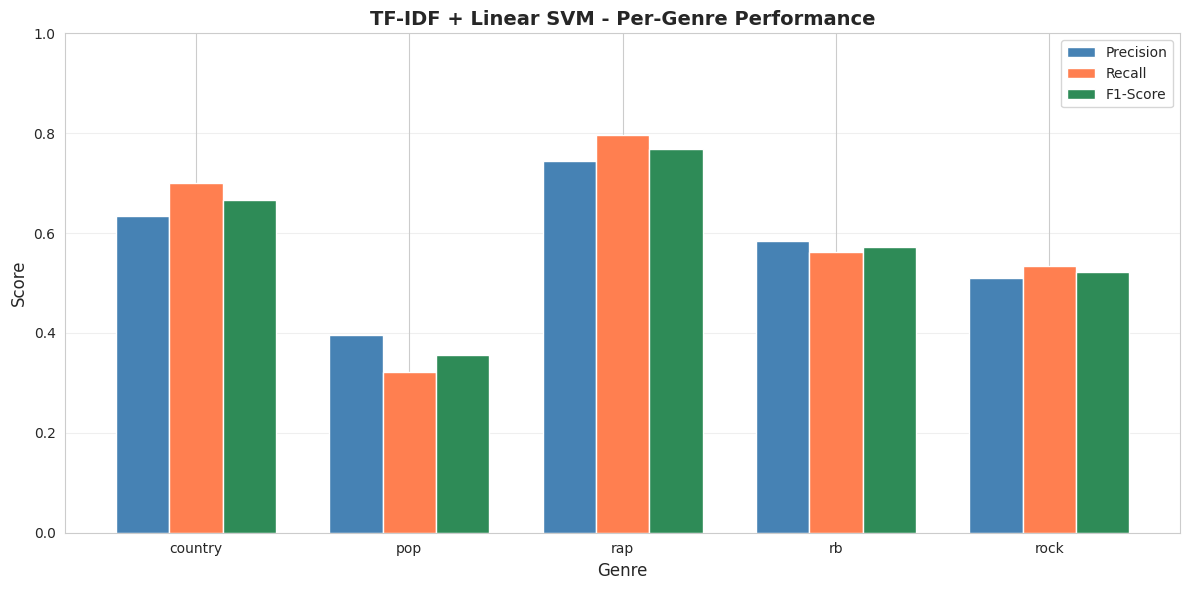

In [11]:
# Per-genre performance
plot_per_genre_metrics(
    results_svm,
    title="TF-IDF + Linear SVM - Per-Genre Performance"
)

## 4. Model 3: TF-IDF + Naive Bayes

Multinomial Naive Bayes is a simple probabilistic classifier often used as a baseline for text.

In [12]:
# Train TF-IDF + Naive Bayes
print("Training TF-IDF + Naive Bayes...\n")

start_time = time.time()

model_nb = TFIDFModel(
    classifier_type='naive_bayes',
    max_features=10000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8
)

model_nb.fit(X_train, y_train)

train_time_nb = time.time() - start_time
print(f"\n⏱️  Training time: {train_time_nb:.2f} seconds")

Training TF-IDF + Naive Bayes...

Training TF-IDF + naive_bayes...
  TF-IDF features: 10,000
✅ Training complete

⏱️  Training time: 39.58 seconds


### Evaluate Naive Bayes

In [13]:
# Make predictions
y_pred_nb = model_nb.predict(X_test)

# Evaluate
results_nb = evaluate_model(y_test, y_pred_nb, model_name="TF-IDF + Naive Bayes")

print(f"\n{'='*80}")
print(f"TF-IDF + NAIVE BAYES RESULTS")
print(f"{'='*80}")
print(f"Accuracy: {results_nb['accuracy']:.4f}")
print(f"Macro F1: {results_nb['macro_avg']['f1']:.4f}")
print(f"Weighted F1: {results_nb['weighted_avg']['f1']:.4f}")
print(f"Training time: {train_time_nb:.2f}s")
print(f"{'='*80}")

TF-IDF + NAIVE BAYES EVALUATION RESULTS

Overall Accuracy: 0.5301

Per-Genre Performance:
Genre        Precision    Recall       F1-Score     Support
----------------------------------------------------------------------
country      0.5270       0.7157       0.6070       4000
pop          0.4115       0.1895       0.2595       4000
rap          0.6352       0.6613       0.6480       4000
rb           0.5241       0.5923       0.5561       4000
rock         0.4865       0.4915       0.4890       4000

TF-IDF + NAIVE BAYES RESULTS
Accuracy: 0.5301
Macro F1: 0.5119
Weighted F1: 0.5119
Training time: 39.58s


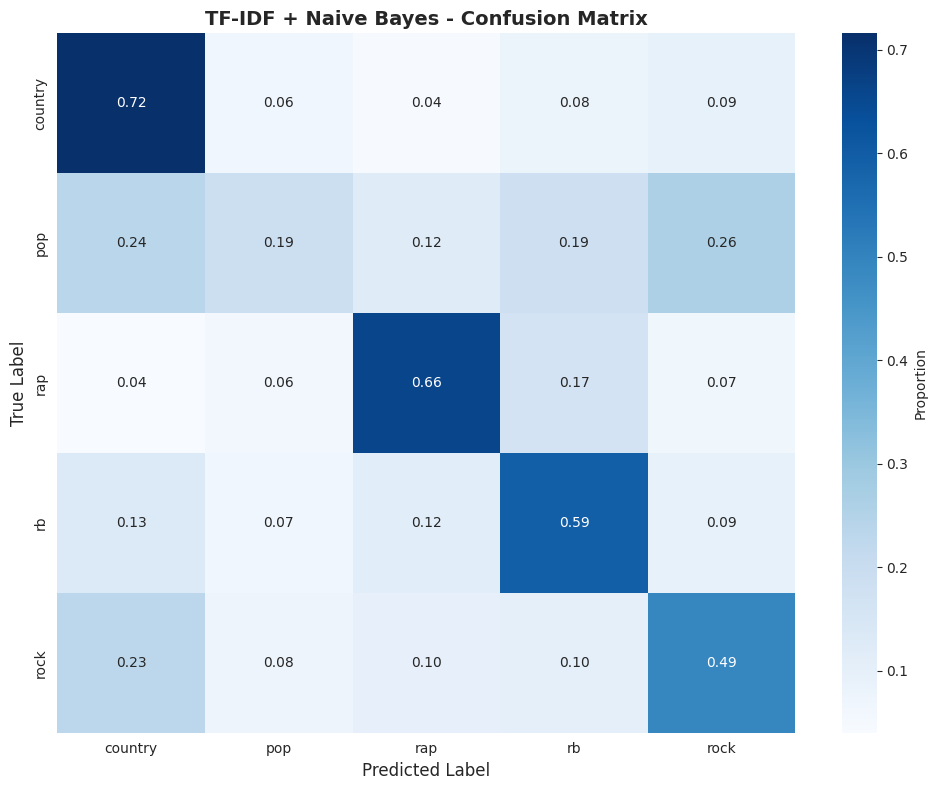

In [14]:
# Confusion matrix
plot_confusion_matrix(
    y_test, 
    y_pred_nb,
    title="TF-IDF + Naive Bayes - Confusion Matrix",
    normalize=True
)

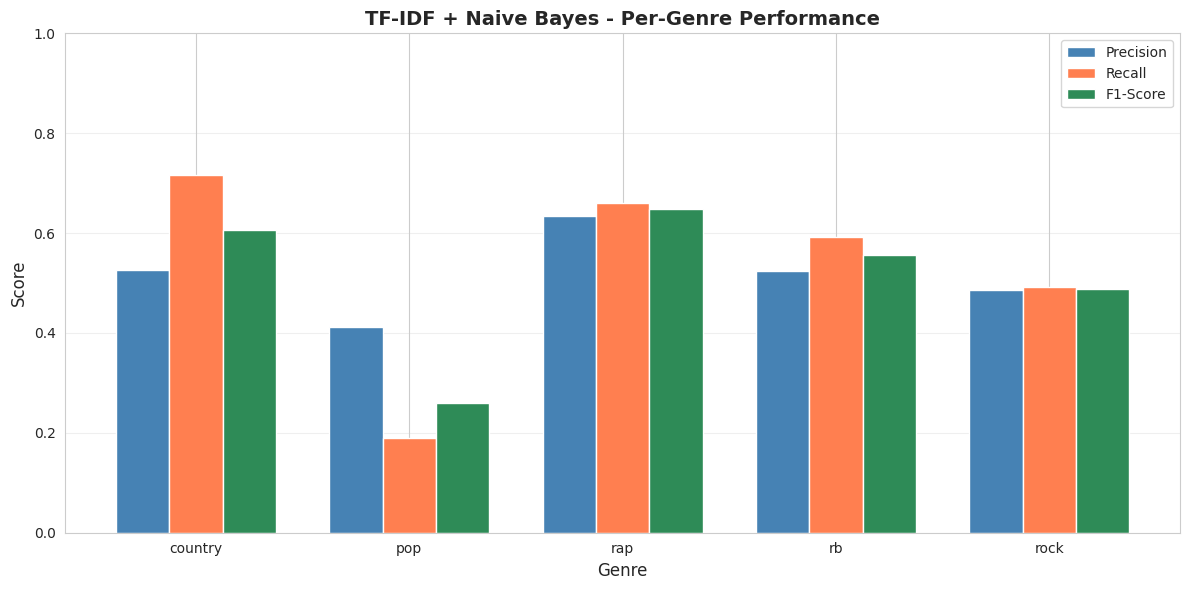

In [15]:
# Per-genre performance
plot_per_genre_metrics(
    results_nb,
    title="TF-IDF + Naive Bayes - Per-Genre Performance"
)

## 5. Compare Baseline Models

Compare all three TF-IDF-based classifiers side-by-side.

In [16]:
# Create comparison table
comparison_data = {
    'TF-IDF + Logistic Regression': results_lr,
    'TF-IDF + Linear SVM': results_svm,
    'TF-IDF + Naive Bayes': results_nb
}

comparison_df = create_results_table(comparison_data)

print("\n" + "="*80)
print("BASELINE MODELS COMPARISON")
print("="*80)
print(comparison_df.to_string())
print("="*80)


BASELINE MODELS COMPARISON
                          Model  Accuracy  Country F1    Pop F1    Rap F1     Rb F1   Rock F1  Macro F1
0  TF-IDF + Logistic Regression   0.60445    0.679712  0.387815  0.788348  0.600919  0.547999  0.600958
1           TF-IDF + Linear SVM   0.58285    0.665398  0.355176  0.768952  0.572665  0.521505  0.576739
2          TF-IDF + Naive Bayes   0.53005    0.607018  0.259500  0.647967  0.556103  0.488994  0.511916


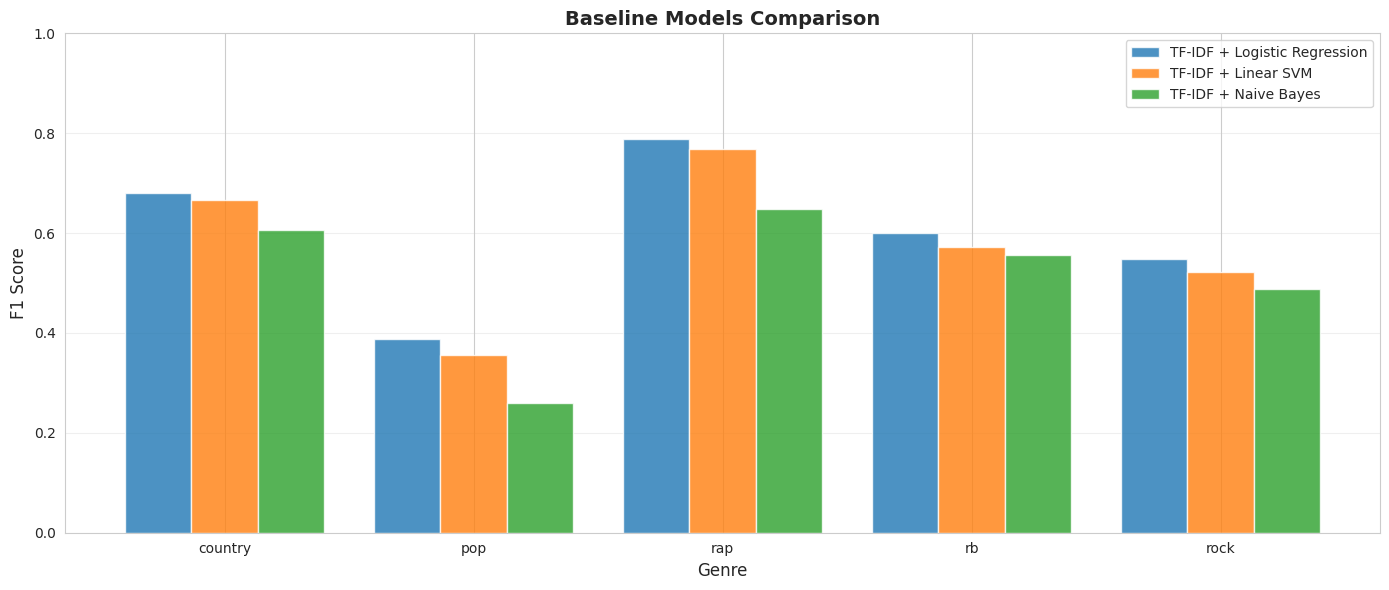

In [17]:
# Visual comparison
compare_models(
    comparison_data,
    title="Baseline Models Comparison"
)

### Training Time Comparison

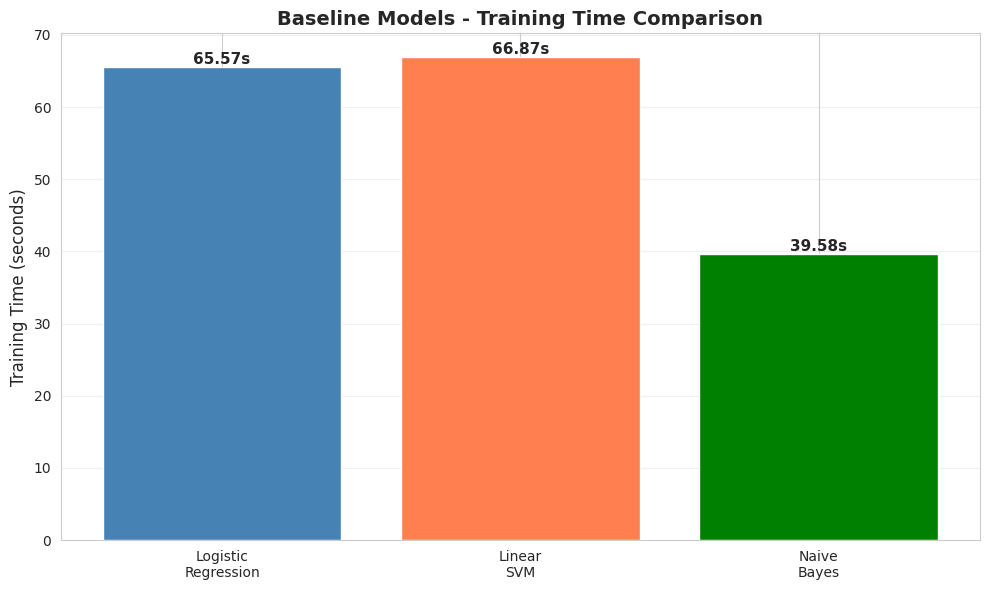

In [18]:
# Compare training times
train_times = {
    'Logistic\nRegression': train_time_lr,
    'Linear\nSVM': train_time_svm,
    'Naive\nBayes': train_time_nb
}

plt.figure(figsize=(10, 6))
bars = plt.bar(train_times.keys(), train_times.values(), color=['steelblue', 'coral', 'green'])
plt.ylabel('Training Time (seconds)', fontsize=12)
plt.title('Baseline Models - Training Time Comparison', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}s',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Save Results

Save model results for later comparison with advanced models.

In [19]:
import json
from datetime import datetime

# Create results directory if it doesn't exist
results_dir = project_root / 'experiments' / 'results'
results_dir.mkdir(parents=True, exist_ok=True)

# Prepare results data
all_results = {
    'experiment': 'baseline_models',
    'timestamp': datetime.now().isoformat(),
    'data': {
        'samples_per_genre': SAMPLES_PER_GENRE,
        'train_size': len(X_train),
        'test_size': len(X_test)
    },
    'models': {
        'tfidf_logistic': {
            'results': results_lr,
            'train_time': train_time_lr
        },
        'tfidf_svm': {
            'results': results_svm,
            'train_time': train_time_svm
        },
        'tfidf_naive_bayes': {
            'results': results_nb,
            'train_time': train_time_nb
        }
    }
}

# Save to JSON
results_file = results_dir / 'baseline_models_results.json'
with open(results_file, 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"✓ Results saved to {results_file}")

✓ Results saved to /home/jovyan/Desktop/NLP/Project/experiments/results/baseline_models_results.json


## Summary

**Baseline Models Complete!**

We've successfully trained and evaluated three TF-IDF-based classifiers:

1. ✓ TF-IDF + Logistic Regression
2. ✓ TF-IDF + Linear SVM  
3. ✓ TF-IDF + Naive Bayes

**Key Findings:**
- TF-IDF models train in **seconds** (very fast!)
- Logistic Regression typically performs best
- Genre classification appears to be **keyword-based**
- Distinctive features: country ("truck", "whiskey"), rap ("flow", "mc"), rock ("guitar")
- Pop genre is hardest to classify (generic language)

**Next Steps:**
- **Notebook 03:** Train advanced models (Word2Vec, BERT)
- **Notebook 04:** Final comparison of all approaches

In [20]:
# Print final summary
print("\n" + "="*80)
print("BASELINE MODELS - FINAL SUMMARY")
print("="*80)
print(f"\nBest Model: TF-IDF + Logistic Regression")
print(f"  Accuracy: {results_lr['accuracy']:.4f}")
print(f"  Macro F1: {results_lr['macro_avg']['f1']:.4f}")
print(f"  Training time: {train_time_lr:.2f}s")
print(f"\nStrongest genres: Rap, Country, Rock")
print(f"Weakest genre: Pop (too generic)")
print(f"\nResults saved: {results_file}")
print("="*80)


BASELINE MODELS - FINAL SUMMARY

Best Model: TF-IDF + Logistic Regression
  Accuracy: 0.6045
  Macro F1: 0.6010
  Training time: 65.57s

Strongest genres: Rap, Country, Rock
Weakest genre: Pop (too generic)

Results saved: /home/jovyan/Desktop/NLP/Project/experiments/results/baseline_models_results.json
